In [61]:
import torch

In [62]:
import pandas as pd

In [63]:
import torch_geometric
from torch_geometric.data import Dataset, Data
import numpy as np 
import os
from tqdm import tqdm

In [64]:
import torch.nn.functional as F 
from torch.nn import Linear, BatchNorm1d, ModuleList
from torch_geometric.nn import TransformerConv, TopKPooling 
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
# torch.manual_seed(42)

In [65]:
import mlflow.pytorch

In [66]:
print(f"Torch version: {torch.__version__}")
print(f"Cuda available: {torch.cuda.is_available()}")
print(f"Torch geometric version: {torch_geometric.__version__}")

Torch version: 1.11.0
Cuda available: True
Torch geometric version: 2.0.4


## Dataset Creation

https://github.com/quarkslab/dataset-call-graph-blogpost-material

https://colab.research.google.com/drive/17JFlnMUjcsMmXQYXF8xZ3z169VDAwUls?authuser=1

https://www.youtube.com/watch?v=QLIkOtKS4os&list=PLV8yxwGOxvvoNkzPfCx2i8an--Tkt7O8Z&index=9

In [67]:
# test_dataset = MoleculeDataset(root="data/", filename="HIV_test.csv", test=True)

In [68]:
import pickle
path_temp= "dataset-call-graph-blogpost-material/dataset/"

In [69]:
good_data=pickle.load(open(path_temp+"goodware_graphs.p","rb"))
bad_data=pickle.load(open(path_temp+"malware_graphs.p","rb"))

In [70]:
print("length of array = ",len(good_data))
print("length of 1 item = ",len(good_data[0]))
print("length of first thing in one item = ",len(good_data[0][0]))
print("length of second thing in one item = ",len(good_data[0][1]))

length of array =  546
length of 1 item =  2
length of first thing in one item =  464
length of second thing in one item =  464


In [71]:
node_feature_menu=['mov', 'call', 'lea', 'jmp', 'push', 'add', 'xor', 'cmp', 'int3', 'nop', 'pushl', 'dec', 'sub', 'insl', 'inc','jz', 'jnz', 'je', 'jne', 'ja', 'jna', 'js', 'jns', 'jl', 'jnl', 'jg', 'jng']

In [122]:

class MoleculeDataset(Dataset):
    def __init__(self, root, filename,good_data, bad_data, test=False, transform=None, pre_transform=None):
        """
        root = Where the dataset should be stored. This folder is split
        into raw_dir (downloaded dataset) and processed_dir (processed data). 
        """
        self.test = test
        self.filename = filename
        self.good_data=good_data
        self.bad_data=bad_data
        super(MoleculeDataset, self).__init__(root, transform, pre_transform)
        self.data_passed=self.good_data+self.bad_data
        
    @property
    def raw_file_names(self):
        """ If this file exists in raw_dir, the download is not triggered.
            (The download func. is not implemented here)  
        """
        return ["goodware_graphs.p","malware_graphs.p"]

    @property
    def processed_file_names(self):
        """ If these files are found in raw_dir, processing is skipped"""
#         self.data = self.data_passed
        return "NOt implemented yet"

        # if self.test:
        #     return [f'data_test_{i}.pt' for i in list(self.data.index)]
        # else:
        #     return [f'data_{i}.pt' for i in list(self.data.index)]

    def download(self):
        pass

    def process(self):
#         self.data = self.data_passed
        print("started doing stuff")
        index=0

        for mol in (self.good_data):
            

            feature_data=mol[0]
            neighbour_data=mol[1]

            # i need to create inst ->index
            instr_index=dict()
            for a,b in enumerate(feature_data):
              instr_index[b]=a 

            # Get node features
            node_feats = self._get_node_features(feature_data,instr_index)
            # Get edge features
            edge_feats = self._get_edge_features(neighbour_data)
#             edge_feats = []
            # Get adjacency info
            edge_index = self._get_adjacency_info(neighbour_data,instr_index)

            # Get labels info
            label = 1

            # Create data object
            data = Data(x=node_feats, 
                        edge_index=edge_index,
                        edge_attr=edge_feats,
                        y=label,
                        smiles=mol
                        ) 
                        
            torch.save(data, 
                    os.path.join(self.processed_dir, 
                                 f'data_{index}.pt'))

            index+=1
        
        for mol in (self.bad_data):
            

            feature_data=mol[0]
            neighbour_data=mol[1]

            # i need to create inst ->index
            instr_index=dict()
            for a,b in enumerate(feature_data):
              instr_index[b]=a 

            # Get node features
            node_feats = self._get_node_features(feature_data,instr_index)
            # Get edge features
            edge_feats = self._get_edge_features(neighbour_data)
#             edge_feats = []
            # Get adjacency info
            edge_index = self._get_adjacency_info(neighbour_data,instr_index)

            # Get labels info
            label = 0

            # Create data object
            data = Data(x=node_feats, 
                        edge_index=edge_index,
                        edge_attr=edge_feats,
                        y=label,
                        smiles=mol
                        ) 
                        
            torch.save(data, 
                    os.path.join(self.processed_dir, 
                                 f'data_{index}.pt'))

            index+=1
        
        

    def process_node_features(self,val, node_feature_menu):
      # print("jj")
      # print(val)
      node_out=[]
      keys=val.keys()
      for name in node_feature_menu : 
        if(name in keys):
          node_out.append(val[name])
        else:
          node_out.append(0)
      return node_out


    def _get_node_features(self, node_features,instr_index):
        """ 
        This will return a matrix / 2d array of the shape
        [Number of Nodes, Node Feature size]
        """
        node_feature_menu=['mov', 'call', 'lea', 'jmp', 'push', 'add', 'xor', 'cmp', 'int3', 'nop', 'pushl', 'dec', 'sub', 'insl', 'inc','jz', 'jnz', 'je', 'jne', 'ja', 'jna', 'js', 'jns', 'jl', 'jnl', 'jg', 'jng']

        all_node_feats = []

        for atom in node_features:
            # print("atom is",atom)
            
            node_feats = []
            node_feats = self.process_node_features(node_features[atom],node_feature_menu)
            # Append node features to matrix
            all_node_feats.append(node_feats)

        all_node_feats = np.asarray(all_node_feats)
        return torch.tensor(all_node_feats, dtype=torch.float)

    def _get_edge_features(self, mol):
        """ 
        This will return a matrix / 2d array of the shape
        [Number of edges, Edge Feature size]
        """
        all_edge_feats = []

        # for bond in mol.GetBonds():
        #     edge_feats = []
        #     # Feature 1: Bond type (as double)
        #     edge_feats.append(bond.GetBondTypeAsDouble())
        #     # Feature 2: Rings
        #     edge_feats.append(bond.IsInRing())
        #     # Append node features to matrix (twice, per direction)
        #     all_edge_feats += [edge_feats, edge_feats]

        all_edge_feats = np.asarray(all_edge_feats)
        return torch.tensor(all_edge_feats, dtype=torch.float)

    def get_one_instr_adjacency(self,val,instr_index,self_instruction_number):
        edge_val=[]
        for a in val:
            edge_val+=[[instr_index[self_instruction_number],instr_index[a]]]

        return edge_val

    def _get_adjacency_info(self, mol, instr_index):
        """
        We could also use rdmolops.GetAdjacencyMatrix(mol)
        but we want to be sure that the order of the indices
        matches the order of the edge features
        """
        edge_indices = []
        for bond in mol:
            edge_indices += self.get_one_instr_adjacency(mol[bond],instr_index,bond)

        edge_indices = torch.tensor(edge_indices)
        edge_indices = edge_indices.t().to(torch.long).view(2, -1)
        return edge_indices

    def _get_labels(self, label):
        label = np.asarray([label])
        return torch.tensor(label, dtype=torch.int64)

    def len(self):
#         return self.data_pass.shape[0]
        return len(self.data_passed)

    def get(self, idx):
        """ - Equivalent to __getitem__ in pytorch
            - Is not needed for PyG's InMemoryDataset
        """
        data = torch.load(os.path.join(self.processed_dir, 
                             f'data_{idx}.pt'))
        return data





In [123]:
train_dataset = MoleculeDataset(root="data/", filename="goodware_graphs.p", good_data=good_data, bad_data=bad_data)

Processing...


started doing stuff


Done!


In [124]:
print(train_dataset[600])

Data(x=[1222, 27], edge_index=[2, 3265], edge_attr=[0], y=0, smiles=[2])


In [125]:
print(train_dataset[1].edge_index.t())

tensor([[  1, 437],
        [  2,   4],
        [  3, 412],
        ...,
        [491, 142],
        [491, 289],
        [491, 135]])


In [126]:
print(train_dataset[1].x)

tensor([[ 4.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        ...,
        [11.,  0.,  2.,  ...,  0.,  0.,  0.],
        [ 7.,  4.,  2.,  ...,  0.,  0.,  0.],
        [26., 10.,  0.,  ...,  0.,  0.,  0.]])


In [176]:
len(node_feature_menu)

27

## MODEL

In [196]:
import torch
import torch.nn.functional as F 
from torch.nn import Sequential, Linear, BatchNorm1d, ReLU
from torch_geometric.nn import TransformerConv, GATConv, TopKPooling, BatchNorm
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.nn.conv.x_conv import XConv
torch.manual_seed(42)

class GNN(torch.nn.Module):
    def __init__(self, feature_size):
        super(GNN, self).__init__()
        num_classes = 2
        embedding_size = 27

        # GNN layers
        self.conv1 = GATConv(feature_size, embedding_size, heads=3, dropout=0.3)
        self.head_transform1 = Linear(embedding_size*3, embedding_size)
        self.pool1 = TopKPooling(embedding_size, ratio=0.8)
        self.conv2 = GATConv(embedding_size, embedding_size, heads=3, dropout=0.3)
        self.head_transform2 = Linear(embedding_size*3, embedding_size)
        self.pool2 = TopKPooling(embedding_size, ratio=0.5)
        self.conv3 = GATConv(embedding_size, embedding_size, heads=3, dropout=0.3)
        self.head_transform3 = Linear(embedding_size*3, embedding_size)
        self.pool3 = TopKPooling(embedding_size, ratio=0.2)

        # Linear layers
        self.linear1 = Linear(embedding_size*2, 1024)
        self.linear2 = Linear(1024, num_classes)  

    def forward(self, x, edge_attr, edge_index, batch_index):
        # First block
        x = self.conv1(x, edge_index)
        x = self.head_transform1(x)

        x, edge_index, edge_attr, batch_index, _, _ = self.pool1(x, 
                                                        edge_index, 
                                                        None, 
                                                        batch_index)
        x1 = torch.cat([gmp(x, batch_index), gap(x, batch_index)], dim=1)

        # Second block
        x = self.conv2(x, edge_index)
        x = self.head_transform2(x)
        x, edge_index, edge_attr, batch_index, _, _ = self.pool2(x, 
                                                        edge_index, 
                                                        None, 
                                                        batch_index)
        x2 = torch.cat([gmp(x, batch_index), gap(x, batch_index)], dim=1)

        # Third block
        x = self.conv3(x, edge_index)
        x = self.head_transform3(x)
        x, edge_index, edge_attr, batch_index, _, _ = self.pool3(x, 
                                                        edge_index, 
                                                        None, 
                                                        batch_index)
        x3 = torch.cat([gmp(x, batch_index), gap(x, batch_index)], dim=1)

        # Concat pooled vectors
        x = x1 + x2 + x3

        # Output block
        x = self.linear1(x).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.linear2(x)

        return x


In [197]:
import torch 
from torch_geometric.data import DataLoader
from sklearn.metrics import confusion_matrix, f1_score, \
    accuracy_score, precision_score, recall_score, roc_auc_score
import numpy as np
from tqdm import tqdm
# from dataset_featurizer import MoleculeDataset
# from model import GNN
import mlflow.pytorch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)





Number of parameters: 72383


GNN(
  (conv1): GATConv(27, 27, heads=3)
  (head_transform1): Linear(in_features=81, out_features=27, bias=True)
  (pool1): TopKPooling(27, ratio=0.8, multiplier=1.0)
  (conv2): GATConv(27, 27, heads=3)
  (head_transform2): Linear(in_features=81, out_features=27, bias=True)
  (pool2): TopKPooling(27, ratio=0.5, multiplier=1.0)
  (conv3): GATConv(27, 27, heads=3)
  (head_transform3): Linear(in_features=81, out_features=27, bias=True)
  (pool3): TopKPooling(27, ratio=0.2, multiplier=1.0)
  (linear1): Linear(in_features=54, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=2, bias=True)
)

In [248]:

BEST_PARAMETERS = {
    "batch_size": [128],
    "learning_rate": [0.01],
    "weight_decay": [0.0001],
    "sgd_momentum": [0.8],
    "scheduler_gamma": [0.8],
    "pos_weight": [1.3],
    "model_embedding_size": [64],
    "model_attention_heads": [3],
    "model_layers": [4],
    "model_dropout_rate": [0.2],
    "model_top_k_ratio": [0.5],
    "model_top_k_every_n": [1],
    "model_dense_neurons": [256]
}

In [ ]:
weight_decay=params["weight_decay"]

In [251]:
# #%% Loss and Optimizer
# # new one 

# # weights = torch.tensor([1, 20], dtype=torch.float32).to(device)
# # loss_fn = torch.nn.CrossEntropyLoss(weight=weights)

# weight2 = torch.tensor([BEST_PARAMETERS["pos_weight"]], dtype=torch.float32).to(device)
# loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=weight2)

# optimizer = torch.optim.SGD(model.parameters(), lr=BEST_PARAMETERS['learning_rate'], momentum=BEST_PARAMETERS['sgd_momentum'], weight_decay=BEST_PARAMETERS["weight_decay"])  
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=BEST_PARAMETERS["scheduler_gamma"])


In [265]:
#%% Loss and Optimizer
# original
weights = torch.tensor([1, 3], dtype=torch.float32).to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.8)  
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)


In [266]:
optimizer.zero_grad()        
# loss, hidden = model(data, hidden, targets)
# loss.backward()
clip_value=10
torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
optimizer.step()

In [267]:
weights

tensor([1., 3.], device='cuda:0')

In [268]:
#%% Prepare training
NUM_GRAPHS_PER_BATCH = 256
# NUM_GRAPHS_PER_BATCH = 1

train_loader = DataLoader(train_dataset, 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True,
                         num_workers=0)
# test_loader = DataLoader(test_dataset, 
#                          batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(train_dataset, 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)


D:\Anaconda3\envs\pytorch\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [269]:
def test(epoch):
    all_preds = []
    all_labels = []
    for batch in test_loader:
        batch.to(device)  
        pred = model(batch.x.float(), 
                        batch.edge_attr.float(),
                        batch.edge_index, 
                        batch.batch) 
        loss = torch.sqrt(loss_fn(pred, batch.y))    
        all_preds.append(np.argmax(pred.cpu().detach().numpy(), axis=1))
        all_labels.append(batch.y.cpu().detach().numpy())

    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate(all_labels).ravel()
    calculate_metrics(all_preds, all_labels, epoch, "test")
    return loss


def calculate_metrics(y_pred, y_true, epoch, type):
    print(f"\n Confusion matrix: \n {confusion_matrix(y_pred, y_true)}")
    print(f"F1 Score: {f1_score(y_pred, y_true)}")
    print(f"Accuracy: {accuracy_score(y_pred, y_true)}")
    print(f"Precision: {precision_score(y_pred, y_true)}")
    print(f"Recall: {recall_score(y_pred, y_true)}")
    try:
        roc = roc_auc_score(y_pred, y_true)
        print(f"ROC AUC: {roc}")
        mlflow.log_metric(key=f"ROC-AUC-{type}", value=float(roc), step=epoch)
    except:
        mlflow.log_metric(key=f"ROC-AUC-{type}", value=float(0), step=epoch)
        print(f"ROC AUC: notdefined")
        
    try:
        mlflow.log_metric(key=f"accuracy-{type}", value=float(accuracy_score(y_pred, y_true)), step=epoch)
    except:
        mlflow.log_metric(key=f"ROC-AUC-{type}", value=float(0), step=epoch)
        print(f"Accuracy: notdefined")

In [270]:

def train(epoch):
    # Enumerate over the data
    all_preds = []
    all_labels = []
    for _, batch in enumerate(tqdm(train_loader)):
        # Use GPU
        batch.to(device)  
        # Reset gradients

        optimizer.zero_grad() 
        # Passing the node features and the connection info
        pred = model(batch.x.float(), 
                                batch.edge_attr.float(),
                                batch.edge_index, 
                                batch.batch) 
        # Calculating the loss and gradients
#         loss = torch.sqrt(loss_fn(pred, batch.y)) 
        loss_v1 = loss_fn(pred, batch.y) 
        loss_v2=torch.sqrt(loss_v1)
#         print("batch.y")
#         print(batch.y)
        
#         print("pred")
#         print(pred)
        
#         print("loss_v1")
#         print(loss_v1)
#         print("loss_v2")
#         print(loss_v2)
        
        loss=loss_v2
        loss.backward()  
        # Update using the gradients
        optimizer.step()  

        all_preds.append(np.argmax(pred.cpu().detach().numpy(), axis=1))
        all_labels.append(batch.y.cpu().detach().numpy())
    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate(all_labels).ravel()
    calculate_metrics(all_preds, all_labels, epoch, "train")
    return loss




In [271]:
#%% Loading the model
model = GNN(feature_size=train_dataset[0].x.shape[1]) 
model = model.to(device)
print(f"Number of parameters: {count_parameters(model)}")
model

Number of parameters: 72383


GNN(
  (conv1): GATConv(27, 27, heads=3)
  (head_transform1): Linear(in_features=81, out_features=27, bias=True)
  (pool1): TopKPooling(27, ratio=0.8, multiplier=1.0)
  (conv2): GATConv(27, 27, heads=3)
  (head_transform2): Linear(in_features=81, out_features=27, bias=True)
  (pool2): TopKPooling(27, ratio=0.5, multiplier=1.0)
  (conv3): GATConv(27, 27, heads=3)
  (head_transform3): Linear(in_features=81, out_features=27, bias=True)
  (pool3): TopKPooling(27, ratio=0.2, multiplier=1.0)
  (linear1): Linear(in_features=54, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=2, bias=True)
)

In [272]:

# %% Run the training
with mlflow.start_run() as run:
    for epoch in range(50):
        # Training
        model.train()
        loss = train(epoch=epoch)
        loss = loss.detach().cpu().numpy()
        print(f"Epoch {epoch} | Train Loss {loss}")
        mlflow.log_metric(key="Train loss", value=float(loss), step=epoch)

        # Testing
        model.eval()
        if epoch % 5 == 0:
            loss = test(epoch=epoch)
            loss = loss.detach().cpu().numpy()
            print(f"Epoch {epoch} | Test Loss {loss}")
            mlflow.log_metric(key="Test loss", value=float(loss), step=epoch)

        scheduler.step()
print("Done.")



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:25<00:00,  4.26s/it]



 Confusion matrix: 
 [[153  89]
 [662 457]]
F1 Score: 0.548948948948949
Accuracy: 0.4481998530492285
Precision: 0.836996336996337
Recall: 0.40840035746201964
ROC AUC: 0.5203158812103487
Epoch 0 | Train Loss 1.2799426317214966

 Confusion matrix: 
 [[ 28  25]
 [787 521]]
F1 Score: 0.5620280474649406
Accuracy: 0.4033798677443057
Precision: 0.9542124542124543
Recall: 0.3983180428134557
ROC AUC: 0.4633099648029543
Epoch 0 | Test Loss 1.0573097467422485


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:22<00:00,  3.83s/it]



 Confusion matrix: 
 [[154 106]
 [661 440]]
F1 Score: 0.5343047965998786
Accuracy: 0.43644379132990446
Precision: 0.8058608058608059
Recall: 0.3996366939146231
ROC AUC: 0.49597219311115776
Epoch 1 | Train Loss 2.0383825302124023


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:25<00:00,  4.28s/it]



 Confusion matrix: 
 [[161 110]
 [654 436]]
F1 Score: 0.5330073349633252
Accuracy: 0.43864805290227776
Precision: 0.7985347985347986
Recall: 0.4
ROC AUC: 0.4970479704797047
Epoch 2 | Train Loss 1.9191949367523193


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:25<00:00,  4.18s/it]



 Confusion matrix: 
 [[149  90]
 [666 456]]
F1 Score: 0.5467625899280576
Accuracy: 0.44452608376193975
Precision: 0.8351648351648352
Recall: 0.40641711229946526
ROC AUC: 0.5149240373212808
Epoch 3 | Train Loss 2.298143148422241


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:24<00:00, 14.03s/it]



 Confusion matrix: 
 [[152  94]
 [663 452]]
F1 Score: 0.5442504515352197
Accuracy: 0.443791329904482
Precision: 0.8278388278388278
Recall: 0.4053811659192825
ROC AUC: 0.5116336723905356
Epoch 4 | Train Loss 1.8502306938171387


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:32<00:00,  5.33s/it]



 Confusion matrix: 
 [[152  91]
 [663 455]]
F1 Score: 0.546875
Accuracy: 0.44599559147685525
Precision: 0.8333333333333334
Recall: 0.4069767441860465
ROC AUC: 0.5162455737391138
Epoch 5 | Train Loss 1.9544857740402222

 Confusion matrix: 
 [[ 28  26]
 [787 520]]
F1 Score: 0.5612520237452779
Accuracy: 0.4026451138868479
Precision: 0.9523809523809523
Recall: 0.3978576893649579
ROC AUC: 0.45818810394173826
Epoch 5 | Test Loss 1.0350865125656128


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:24<00:00, 14.06s/it]



 Confusion matrix: 
 [[154 114]
 [661 432]]
F1 Score: 0.5271507016473459
Accuracy: 0.4305657604702425
Precision: 0.7912087912087912
Recall: 0.39524245196706315
ROC AUC: 0.4849346588193525
Epoch 6 | Train Loss 1.465887427330017


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:52<00:00,  8.70s/it]



 Confusion matrix: 
 [[151 116]
 [664 430]]
F1 Score: 0.524390243902439
Accuracy: 0.42689199118295373
Precision: 0.7875457875457875
Recall: 0.3930530164533821
ROC AUC: 0.4792980438072154
Epoch 7 | Train Loss 1.9789059162139893


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:57<00:00,  9.62s/it]



 Confusion matrix: 
 [[138  94]
 [677 452]]
F1 Score: 0.5397014925373134
Accuracy: 0.43350477590007347
Precision: 0.8278388278388278
Recall: 0.4003542958370239
ROC AUC: 0.4975909410219602
Epoch 8 | Train Loss 2.4653375148773193


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:23<00:00,  3.99s/it]



 Confusion matrix: 
 [[152  87]
 [663 459]]
F1 Score: 0.5503597122302158
Accuracy: 0.44893460690668624
Precision: 0.8406593406593407
Recall: 0.4090909090909091
ROC AUC: 0.5225370863446177
Epoch 9 | Train Loss 1.907886028289795


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:22<00:00,  3.81s/it]



 Confusion matrix: 
 [[144 108]
 [671 438]]
F1 Score: 0.5293051359516617
Accuracy: 0.4276267450404115
Precision: 0.8021978021978022
Recall: 0.39495040577096485
ROC AUC: 0.4831894885997681
Epoch 10 | Train Loss 1.939300537109375

 Confusion matrix: 
 [[ 28  26]
 [787 520]]
F1 Score: 0.5612520237452779
Accuracy: 0.4026451138868479
Precision: 0.9523809523809523
Recall: 0.3978576893649579
ROC AUC: 0.45818810394173826
Epoch 10 | Test Loss 1.3103300333023071


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:23<00:00,  3.85s/it]



 Confusion matrix: 
 [[159  90]
 [656 456]]
F1 Score: 0.5500603136308806
Accuracy: 0.4518736223365173
Precision: 0.8351648351648352
Recall: 0.41007194244604317
ROC AUC: 0.5243130796567566
Epoch 11 | Train Loss 1.9164602756500244


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:23<00:00,  3.96s/it]



 Confusion matrix: 
 [[148 103]
 [667 443]]
F1 Score: 0.535024154589372
Accuracy: 0.4342395297575312
Precision: 0.8113553113553114
Recall: 0.3990990990990991
ROC AUC: 0.4943702666810236
Epoch 12 | Train Loss 2.092238426208496


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:24<00:00,  4.03s/it]



 Confusion matrix: 
 [[147  98]
 [668 448]]
F1 Score: 0.539109506618532
Accuracy: 0.4371785451873622
Precision: 0.8205128205128205
Recall: 0.4014336917562724
ROC AUC: 0.5007168458781361
Epoch 13 | Train Loss 2.128788948059082


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:22<00:00,  3.76s/it]



 Confusion matrix: 
 [[159 101]
 [656 445]]
F1 Score: 0.5403764420157863
Accuracy: 0.443791329904482
Precision: 0.815018315018315
Recall: 0.40417801998183467
ROC AUC: 0.5078582407601482
Epoch 14 | Train Loss 2.69639253616333


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:22<00:00,  3.74s/it]



 Confusion matrix: 
 [[157  98]
 [658 448]]
F1 Score: 0.5423728813559322
Accuracy: 0.44452608376193975
Precision: 0.8205128205128205
Recall: 0.4050632911392405
ROC AUC: 0.5103747828245222
Epoch 15 | Train Loss 1.6392879486083984

 Confusion matrix: 
 [[ 28  26]
 [787 520]]
F1 Score: 0.5612520237452779
Accuracy: 0.4026451138868479
Precision: 0.9523809523809523
Recall: 0.3978576893649579
ROC AUC: 0.45818810394173826
Epoch 15 | Test Loss 0.9649260640144348


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:23<00:00,  3.87s/it]



 Confusion matrix: 
 [[157 100]
 [658 446]]
F1 Score: 0.5406060606060608
Accuracy: 0.44305657604702425
Precision: 0.8168498168498168
Recall: 0.40398550724637683
ROC AUC: 0.5074402244403091
Epoch 16 | Train Loss 2.198795795440674


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:23<00:00,  3.95s/it]



 Confusion matrix: 
 [[161 106]
 [654 440]]
F1 Score: 0.5365853658536586
Accuracy: 0.44158706833210876
Precision: 0.8058608058608059
Recall: 0.40219378427787933
ROC AUC: 0.5025950194797636
Epoch 17 | Train Loss 1.6638087034225464


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:22<00:00,  3.80s/it]



 Confusion matrix: 
 [[140 106]
 [675 440]]
F1 Score: 0.5298013245033112
Accuracy: 0.426157237325496
Precision: 0.8058608058608059
Recall: 0.39461883408071746
ROC AUC: 0.48186226256881404
Epoch 18 | Train Loss 2.001300811767578


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:22<00:00,  3.82s/it]



 Confusion matrix: 
 [[147 102]
 [668 444]]
F1 Score: 0.5355850422195416
Accuracy: 0.4342395297575312
Precision: 0.8131868131868132
Recall: 0.39928057553956836
ROC AUC: 0.4948210106613504
Epoch 19 | Train Loss 2.1605191230773926


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:22<00:00,  3.82s/it]



 Confusion matrix: 
 [[156 112]
 [659 434]]
F1 Score: 0.5295912141549726
Accuracy: 0.43350477590007347
Precision: 0.7948717948717948
Recall: 0.3970722781335773
ROC AUC: 0.4895809151861916
Epoch 20 | Train Loss 1.7950855493545532

 Confusion matrix: 
 [[ 28  26]
 [787 520]]
F1 Score: 0.5612520237452779
Accuracy: 0.4026451138868479
Precision: 0.9523809523809523
Recall: 0.3978576893649579
ROC AUC: 0.45818810394173826
Epoch 20 | Test Loss 0.9520055055618286


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:23<00:00,  3.92s/it]



 Confusion matrix: 
 [[158  93]
 [657 453]]
F1 Score: 0.5471014492753623
Accuracy: 0.44893460690668624
Precision: 0.8296703296703297
Recall: 0.4081081081081081
ROC AUC: 0.5187950899106278
Epoch 21 | Train Loss 1.7186816930770874


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:22<00:00,  3.77s/it]



 Confusion matrix: 
 [[155  94]
 [660 452]]
F1 Score: 0.5452352231604343
Accuracy: 0.44599559147685525
Precision: 0.8278388278388278
Recall: 0.4064748201438849
ROC AUC: 0.5144823899916212
Epoch 22 | Train Loss 2.01395320892334


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:22<00:00,  3.77s/it]



 Confusion matrix: 
 [[148  99]
 [667 447]]
F1 Score: 0.5385542168674698
Accuracy: 0.4371785451873622
Precision: 0.8186813186813187
Recall: 0.4012567324955117
ROC AUC: 0.5002235079481607
Epoch 23 | Train Loss 1.7148845195770264


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:22<00:00,  3.79s/it]



 Confusion matrix: 
 [[131 114]
 [684 432]]
F1 Score: 0.51985559566787
Accuracy: 0.4136664217487142
Precision: 0.7912087912087912
Recall: 0.3870967741935484
ROC AUC: 0.4608953258722844
Epoch 24 | Train Loss 1.9597119092941284


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:23<00:00,  3.86s/it]



 Confusion matrix: 
 [[154  90]
 [661 456]]
F1 Score: 0.5484064942874324
Accuracy: 0.4481998530492285
Precision: 0.8351648351648352
Recall: 0.40823634735899733
ROC AUC: 0.5196919441713019
Epoch 25 | Train Loss 2.2378737926483154

 Confusion matrix: 
 [[ 28  26]
 [787 520]]
F1 Score: 0.5612520237452779
Accuracy: 0.4026451138868479
Precision: 0.9523809523809523
Recall: 0.3978576893649579
ROC AUC: 0.45818810394173826
Epoch 25 | Test Loss 1.119386911392212


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:22<00:00,  3.81s/it]



 Confusion matrix: 
 [[152 102]
 [663 444]]
F1 Score: 0.5372050816696915
Accuracy: 0.43791329904481996
Precision: 0.8131868131868132
Recall: 0.4010840108401084
ROC AUC: 0.49975460384525106
Epoch 26 | Train Loss 1.8447693586349487


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:22<00:00,  3.78s/it]



 Confusion matrix: 
 [[156 105]
 [659 441]]
F1 Score: 0.5358444714459295
Accuracy: 0.43864805290227776
Precision: 0.8076923076923077
Recall: 0.4009090909090909
ROC AUC: 0.4993051201671891
Epoch 27 | Train Loss 2.002556085586548


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:22<00:00,  3.81s/it]



 Confusion matrix: 
 [[152 119]
 [663 427]]
F1 Score: 0.5220048899755501
Accuracy: 0.4254224834680382
Precision: 0.782051282051282
Recall: 0.39174311926605504
ROC AUC: 0.47631436406107175
Epoch 28 | Train Loss 2.270901679992676


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:22<00:00,  3.74s/it]



 Confusion matrix: 
 [[132  98]
 [683 448]]
F1 Score: 0.5342874180083482
Accuracy: 0.426157237325496
Precision: 0.8205128205128205
Recall: 0.39610963748894784
ROC AUC: 0.4850113404836044
Epoch 29 | Train Loss 2.038618803024292


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:24<00:00,  4.07s/it]



 Confusion matrix: 
 [[126 102]
 [689 444]]
F1 Score: 0.5288862418106015
Accuracy: 0.41880969875091845
Precision: 0.8131868131868132
Recall: 0.3918799646954987
ROC AUC: 0.4722557718214335
Epoch 30 | Train Loss 1.7739897966384888

 Confusion matrix: 
 [[ 28  26]
 [787 520]]
F1 Score: 0.5612520237452779
Accuracy: 0.4026451138868479
Precision: 0.9523809523809523
Recall: 0.3978576893649579
ROC AUC: 0.45818810394173826
Epoch 30 | Test Loss 1.1640371084213257


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:22<00:00,  3.70s/it]



 Confusion matrix: 
 [[139 103]
 [676 443]]
F1 Score: 0.5321321321321322
Accuracy: 0.4276267450404115
Precision: 0.8113553113553114
Recall: 0.3958891867739053
ROC AUC: 0.48513467603158067
Epoch 31 | Train Loss 2.0973989963531494


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:23<00:00,  3.85s/it]



 Confusion matrix: 
 [[160 109]
 [655 437]]
F1 Score: 0.5335775335775336
Accuracy: 0.43864805290227776
Precision: 0.8003663003663004
Recall: 0.4001831501831502
ROC AUC: 0.4974893446083037
Epoch 32 | Train Loss 1.4452388286590576


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:22<00:00,  3.75s/it]



 Confusion matrix: 
 [[139 107]
 [676 439]]
F1 Score: 0.5285972305839856
Accuracy: 0.42468772961058043
Precision: 0.8040293040293041
Recall: 0.3937219730941704
ROC AUC: 0.4793813117503372
Epoch 33 | Train Loss 2.0880825519561768


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:22<00:00,  3.80s/it]



 Confusion matrix: 
 [[136 115]
 [679 431]]
F1 Score: 0.5205314009661836
Accuracy: 0.4166054371785452
Precision: 0.7893772893772893
Recall: 0.38828828828828826
ROC AUC: 0.46506047880549867
Epoch 34 | Train Loss 1.8977988958358765


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:22<00:00,  3.78s/it]



 Confusion matrix: 
 [[161 101]
 [654 445]]
F1 Score: 0.541033434650456
Accuracy: 0.4452608376193975
Precision: 0.815018315018315
Recall: 0.4049135577797998
ROC AUC: 0.5097086872868465
Epoch 35 | Train Loss 1.8879090547561646

 Confusion matrix: 
 [[ 28  26]
 [787 520]]
F1 Score: 0.5612520237452779
Accuracy: 0.4026451138868479
Precision: 0.9523809523809523
Recall: 0.3978576893649579
ROC AUC: 0.45818810394173826
Epoch 35 | Test Loss 1.129045844078064


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:23<00:00,  3.93s/it]



 Confusion matrix: 
 [[146  80]
 [669 466]]
F1 Score: 0.5544318857822724
Accuracy: 0.449669360764144
Precision: 0.8534798534798534
Recall: 0.4105726872246696
ROC AUC: 0.528295193169857
Epoch 36 | Train Loss 1.9090299606323242


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:22<00:00,  3.70s/it]



 Confusion matrix: 
 [[164  94]
 [651 452]]
F1 Score: 0.5482110369921164
Accuracy: 0.45260837619397504
Precision: 0.8278388278388278
Recall: 0.4097914777878513
ROC AUC: 0.5227251962582667
Epoch 37 | Train Loss 1.6350857019424438


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:23<00:00,  3.86s/it]



 Confusion matrix: 
 [[135  97]
 [680 449]]
F1 Score: 0.5361194029850747
Accuracy: 0.429096252755327
Precision: 0.8223443223443223
Recall: 0.39769707705934454
ROC AUC: 0.4897968143917412
Epoch 38 | Train Loss 1.885778546333313


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:22<00:00,  3.78s/it]



 Confusion matrix: 
 [[134  99]
 [681 447]]
F1 Score: 0.5340501792114696
Accuracy: 0.42689199118295373
Precision: 0.8186813186813187
Recall: 0.3962765957446808
ROC AUC: 0.48569194594100995
Epoch 39 | Train Loss 1.4562630653381348


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:22<00:00,  3.77s/it]



 Confusion matrix: 
 [[142  99]
 [673 447]]
F1 Score: 0.5366146458583434
Accuracy: 0.4327700220426157
Precision: 0.8186813186813187
Recall: 0.3991071428571429
ROC AUC: 0.49415938055720215
Epoch 40 | Train Loss 1.7929191589355469

 Confusion matrix: 
 [[ 28  26]
 [787 520]]
F1 Score: 0.5612520237452779
Accuracy: 0.4026451138868479
Precision: 0.9523809523809523
Recall: 0.3978576893649579
ROC AUC: 0.45818810394173826
Epoch 40 | Test Loss 1.1353448629379272


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:22<00:00,  3.79s/it]



 Confusion matrix: 
 [[150 103]
 [665 443]]
F1 Score: 0.5356711003627569
Accuracy: 0.4357090374724467
Precision: 0.8113553113553114
Recall: 0.39981949458483756
ROC AUC: 0.49635243503945436
Epoch 41 | Train Loss 2.100379467010498


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:22<00:00,  3.69s/it]



 Confusion matrix: 
 [[150 107]
 [665 439]]
F1 Score: 0.5321212121212121
Accuracy: 0.4327700220426157
Precision: 0.8040293040293041
Recall: 0.3976449275362319
ROC AUC: 0.490651257542435
Epoch 42 | Train Loss 1.6418346166610718


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:23<00:00,  3.86s/it]



 Confusion matrix: 
 [[154  90]
 [661 456]]
F1 Score: 0.5484064942874324
Accuracy: 0.4481998530492285
Precision: 0.8351648351648352
Recall: 0.40823634735899733
ROC AUC: 0.5196919441713019
Epoch 43 | Train Loss 1.9888678789138794


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:23<00:00,  3.86s/it]



 Confusion matrix: 
 [[159  96]
 [656 450]]
F1 Score: 0.5447941888619855
Accuracy: 0.44746509919177074
Precision: 0.8241758241758241
Recall: 0.40687160940325495
ROC AUC: 0.5152005105839804
Epoch 44 | Train Loss 2.2795708179473877


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:23<00:00,  3.92s/it]



 Confusion matrix: 
 [[159 102]
 [656 444]]
F1 Score: 0.5394896719319562
Accuracy: 0.44305657604702425
Precision: 0.8131868131868132
Recall: 0.4036363636363636
ROC AUC: 0.5064158829676071
Epoch 45 | Train Loss 1.6980887651443481

 Confusion matrix: 
 [[ 28  26]
 [787 520]]
F1 Score: 0.5612520237452779
Accuracy: 0.4026451138868479
Precision: 0.9523809523809523
Recall: 0.3978576893649579
ROC AUC: 0.45818810394173826
Epoch 45 | Test Loss 1.1781429052352905


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:22<00:00,  3.74s/it]



 Confusion matrix: 
 [[137  93]
 [678 453]]
F1 Score: 0.5402504472271914
Accuracy: 0.43350477590007347
Precision: 0.8296703296703297
Recall: 0.4005305039787798
ROC AUC: 0.4980913389459117
Epoch 46 | Train Loss 2.3720529079437256


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:22<00:00,  3.79s/it]



 Confusion matrix: 
 [[153 107]
 [662 439]]
F1 Score: 0.533090467516697
Accuracy: 0.43497428361498897
Precision: 0.8040293040293041
Recall: 0.39872842870118075
ROC AUC: 0.4935949835813596
Epoch 47 | Train Loss 2.1009178161621094


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:22<00:00,  3.82s/it]



 Confusion matrix: 
 [[154 102]
 [661 444]]
F1 Score: 0.5378558449424591
Accuracy: 0.4393828067597355
Precision: 0.8131868131868132
Recall: 0.40180995475113124
ROC AUC: 0.5016862273755656
Epoch 48 | Train Loss 1.722983956336975


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:23<00:00,  4.00s/it]



 Confusion matrix: 
 [[159 105]
 [656 441]]
F1 Score: 0.5368228849665246
Accuracy: 0.440852314474651
Precision: 0.8076923076923077
Recall: 0.40200546946216953
ROC AUC: 0.5021390983674484
Epoch 49 | Train Loss 2.3439996242523193
Done.


In [273]:

# %% Save the model 
mlflow.pytorch.log_model(model, "model") 

D:\Anaconda3\envs\pytorch\lib\site-packages\_distutils_hack\__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


ModelInfo(artifact_path='model', flavors={'pytorch': {'model_data': 'data', 'pytorch_version': '1.11.0', 'code': None}, 'python_function': {'pickle_module_name': 'mlflow.pytorch.pickle_module', 'loader_module': 'mlflow.pytorch', 'python_version': '3.9.12', 'data': 'data', 'env': 'conda.yaml'}}, model_uri='runs:/562d75b8ce954b6099f3fa352cbe82c8/model', model_uuid='41c3190ac7294c7ea33b907eb03868a8', run_id='562d75b8ce954b6099f3fa352cbe82c8', saved_input_example_info=None, signature_dict=None, utc_time_created='2022-04-22 21:13:20.492449', mlflow_version='1.25.1')

Confusion Matrix

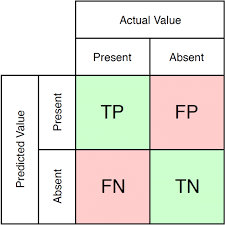